# 03. Query

If WCS(World Coordinate System: converts image XY pixel to, e.g., RA/DEC. See slides 4-7 of [this](http://www.atnf.csiro.au/people/mcalabre/WCS/Intro/WCS01.html), for example) is properly implemented, we should be able to find stars in the image automatically.

``astroquery`` is an [astropy-affiliated python package](https://www.astropy.org/affiliated/) for such query. Here I will demonstrate how to query UCAC4 and Pan-STARRS DR1 catalog, which is one of the most modern and reliable catalogs as of Spring 2019.

## 1. Install ``astroquery``, ``ccdproc`` and ``photutils``
* [``astroquery`` official website](https://astroquery.readthedocs.io/en/latest/)
* [``ccdproc`` official website](https://ccdproc.readthedocs.io/en/stable/)
* [``photutils`` official website](https://photutils.readthedocs.io)
* Additionally ``ysvisutilpy``: 

        git clone https://github.com/ysBach/ysvisutilpy
        cd ysvisutilpy && python setup.py install

I recommend to install via conda:
```
conda install -c astropy photutils ccdproc
```
Also for astroquery, use git clone and install the bleeding-edge version is recommended. (**Otherwise** (not recommended), you can do ``conda install -c astropy astroquery``.)

We will use [``vizier``](https://astroquery.readthedocs.io/en/v0.3.9/vizier/vizier.html) and [``JPLHorizons``](https://astroquery.readthedocs.io/en/v0.3.9/jplhorizons/jplhorizons.html) modules.

## 2. What is VizieR?

[VizieR](http://vizier.u-strasbg.fr) is kind of a repository or online hub for sharing your astronomical catalogs. The catalogs include star catalogs, observational results, etc.
* You can find catalog by name (e.g., try ``UCAC``).
* You can find any catalog which contain your target of interest (e.g., try `` 5:34:32 +22:0:52`` in ``Position``, which is the crab nebula).
* What ``vizier`` module does is to query the online catalog into astropy table and make it easily usable within python.

>The animation below shows how to search Pan-STARRS 1 data release from VizieR. There, you can find which columns are available, and what is the meaning of each column.
>
>![](figs/VizieR_PS1_01.gif)
>
>In the [result page](http://cdsarc.u-strasbg.fr/viz-bin/cat/II/349), you can find the following information:
>
>![](figs/VizieR_PS1_02.png)

## 3. Importing and Setting up
(You don't have to run the first code cell just below)

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-04-30 09:05:16 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 astropy    3.1.2
4 numpy      1.16.2
5 scipy      1.2.1
6 matplotlib 3.0.3
7 astroquery 0.3.9
8 ccdproc    1.3.0.post1
9 photutils  0.6
10 version_information 1.0.3


In [ ]:
%config InlineBackend.figure_format = 'retina'

In [1]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from astroquery.vizier import Vizier
from astroquery.jplhorizons import Horizons

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn

import ysvisutilpy as yvu

from matplotlib import pyplot as plt
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore', append=True, category=UserWarning)


DATAPATH = Path('../..') / 'Tutorial_Data'

In [2]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

## 4. Open FITS and WCS

I will show how to work with a single FITS file. If you want similar task for all the files, you should use for loop. WCS is parsed by [``astropy.wcs.WCS`` module](http://docs.astropy.org/en/stable/wcs/)

In [3]:
allfits = list(DATAPATH.glob("*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header

# Set WCS and print for your information
w = WCS(hdr)
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 204.8640878996  -8.991494826739  
CRPIX : -4068.090526349  5085.76507007  
PC1_1 PC1_2  : -0.0001096993846665  -1.593373136163e-06  
PC2_1 PC2_2  : -2.91576786403e-07  0.0001095957848141  
CDELT : 1.0  1.0  
NAXIS : 999  999


## 5. Query Solar System Object

In the field of view, we have asteroids. As they are nearly circular in shape, I will use circular aperture. But before doing so, we need to find the expected location of the object.

The location of the object, **ephemeris**, is obtained once the following information is given:
* Object name (or orbital elements)
* Observatory
* Observation time

In our case, we will focus on the object [(4179) Toutatis](https://en.wikipedia.org/wiki/4179_Toutatis). The observatory is [SAAO in South Africa](https://en.wikipedia.org/wiki/South_African_Astronomical_Observatory), with IAU observatory code of ``B31``. Observation time is obtainable by ``DATE-OBS + EXPTIME / 2`` where ``DATE-OBS`` and ``EXPTIME`` are available from the image header.

### 5-1. Get Ephemerides from NASA JPL HORIZONS

#### Original HORIZONS Usage

Originally [NASA HORIZONS](https://ssd.jpl.nasa.gov/?horizons) is an ephemerides service for solar system bodies including satellite and spacecrafts. Solar system scientists frequently use the [web interface of HORIZONS](https://ssd.jpl.nasa.gov/horizons.cgi) to get a quick look at a given object at given observatory and observation time.

Go to the [web interface of HORIZONS](https://ssd.jpl.nasa.gov/horizons.cgi), select target, observer location, table setting, and time. 

>For example, the table settings can be selected as below:
>
>![](figs/horizons_01.png)

After generating the ephemerides, you can see the detailed explanations of each column at the bottom part of the result page.

#### Python Version
From python, you can access HORIZONS using ``astroquery``'s ``JPLHorizons`` module, thanks to M. Mommert:

In [4]:
objname = "4179"
observat = "B31"
t_obs = Time(hdr["DATE-OBS"]) + hdr["EXPTIME"] * u.s / 2
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
obj_q = obj.ephemerides()
obj_q.pprint(max_width=100)

       targetname             datetime_str          datetime_jd    ... alpha_true  PABLon  PABLat
          ---                     ---                    d         ...    deg       deg     deg  
----------------------- ------------------------ ----------------- ... ---------- -------- ------
4179 Toutatis (1989 AC) 2018-Apr-13 21:30:56.000 2458222.396481481 ...     0.6463 205.7217 0.5207


The resulting ``obj_q`` contains many columns and they have slightly different names than that of HORIZONS you saw above. They are summarized in [the official documentation](https://astroquery.readthedocs.io/en/v0.3.9/api/astroquery.jplhorizons.HorizonsClass.html#astroquery.jplhorizons.HorizonsClass.ephemerides). Few important columns are
* ``RA`` and ``DEC``: The RA/DEC in degrees.
* ``lighttime``: asteroid-observer distance / c = time delay. The true time of light when it departed the object is, thus, observed time - ``lighttime``.
* ``alpha``: The phase angle in degrees (``alpha`` differ from ``alpha_true`` by only less than around 1 arcmin, so astronomers just use ``alpha``, not ``alpha_true``).

* **QUESTION**: What if observatory has no designated code (e.g., TRIPOL at SNU)?
* **Answer**: The answer is clearly written in the [documentation](https://astroquery.readthedocs.io/en/v0.3.9/jplhorizons/jplhorizons.html). For SNU bldg 45 and 46, you can use ``location=dict(lon=126.95, lat=37.45, elevation=0.1)``.


* **TIP**: In real work, you don't want to query this for every image (as it takes much time). Better way is to obtain the ``t_obs`` for all the images and pass that to the ``epochs`` as python list object. You will learn this in lecture note about ``ysfitsutilpy``.

### 5-2. Convert RA/DEC to Pixel

The only important ones are ``RA`` and ``DEC``! Once we know these, we can convert those to the image XY coordinate by using the WCS information in the header.

I used [``SkyCoord`` object](http://docs.astropy.org/en/stable/coordinates/index.html) here.

In [5]:
pos_sky = SkyCoord(obj_q["RA"][0], obj_q["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=w)
print(pos_sky)
print(pos_pix)

<SkyCoord (ICRS): (ra, dec) in deg
    (204.36167, -9.49665)>
(array(500.49330698), array(500.43540731))


### 5-3. Draw Aperture for Visualization

Here I use [``photutils.aperture`` module](https://photutils.readthedocs.io/en/stable/aperture.html) to visulize the object we found:

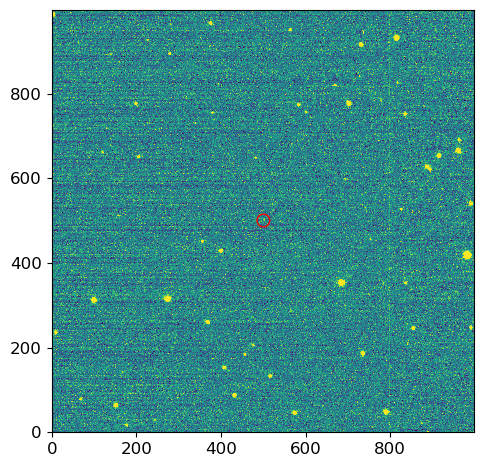

In [6]:
ap_obj = CAp(positions=pos_pix, r=15)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.zimshow(axs, hdul[0].data)
ap_obj.plot(ax=axs, color='r')
plt.tight_layout() 

## 6. Query UCAC Objects
There are two most widely used star catalogs: UCAC and Pan-STARRS. Here we look into UCAC.

### 6-1. UCAC Query

To query UCAC stars, you can simply use [``astroquery.vizier`` module](https://astroquery.readthedocs.io/en/v0.3.9/vizier/vizier.html)

In [7]:
columns = ['+_r', 'RAJ2000', 'DEJ2000', 'mfa', 'No', 'Vmag', 'e_Vmag']
filters = {"Vmag":"10.0..20.0", "e_Vmag":"<10"}
v = Vizier(catalog="UCAC4", columns=columns, column_filters=filters)

v.ROW_LIMIT = -1
# query up to infinitely many rows. By default, this is 50.

image_center = np.array(hdul[0].shape) / 2 - 0.5
cent_coord = w.wcs_pix2world(image_center[0], image_center[1], 0)
# 0 means that we are using 0-indexing. You may use 1 for 1-indexing.
cent_coord = SkyCoord(cent_coord[0], cent_coord[1], unit='deg')

result = v.query_region(cent_coord, catalog="UCAC4", width="0.2d", height="0.2d")

In [8]:
result[0]

_r,RAJ2000,DEJ2000,Vmag,e_Vmag
deg,deg,deg,mag,cmag
float64,float64,float64,float32,bytes2
0.025961,204.3412753,-9.5130048,15.822,06
0.032263,204.3873383,-9.5170259,16.096,01
0.053619,204.3082571,-9.5058348,15.205,02
0.065596,204.3733371,-9.5614173,13.814,04
0.068464,204.2924309,-9.4968520,14.544,07
0.076566,204.4237480,-9.4506095,15.165,07
0.088216,204.3825898,-9.4109975,16.679,01
0.089997,204.3477321,-9.5857223,14.808,06


* **NOTE**: This querying part looks messy. I have made a simple realization of it (and other messy parts before/after this) in ysphotutilpy.
* **Practice**: Try ``print(result)`` and think why I put ``[0]`` at the end of it, which is identical to do ``result['I/322A/out']``. The name in the bracket is the ID of the catalog in VizieR.
* **Practice**: I used ``width="0.2d", height="0.2d"``, which is so-called _hard-coding_. How do you think this can be more generally coded?
  * Hint: Think about ``w_ends = w.wcs_pix2world([[1, 1], [*hdul[0].data.shape]], 0)`` and then ``radius = np.sqrt(np.sum((w_ends[0] - w_ends[1])**2)) / 2 * u.deg`` as below:

In [9]:
w_ends = w.wcs_pix2world([[1, 1], [*hdul[0].data.shape]], 0)
print(w_ends)
radius = np.sqrt(np.sum((w_ends[0] - w_ends[1])**2)) / 2 * u.deg
print(radius.to(u.deg))

[[204.41811988  -9.55146447]
 [204.30540734  -9.44186137]]
0.0786081349221305 deg


### 5-2. Draw Apertures for Visualization

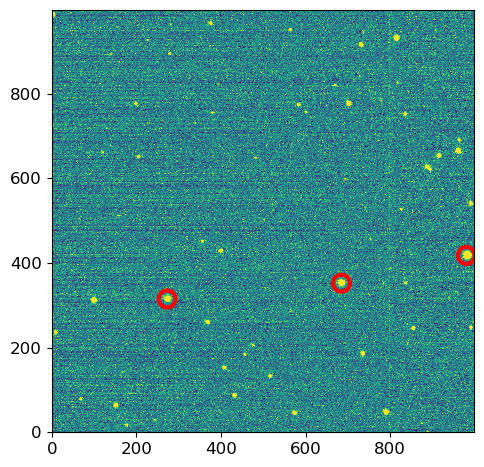

In [11]:
pos_stars = SkyCoord(result[0]["RAJ2000"], result[0]["DEJ2000"], unit='deg')
pos_stars = pos_stars.to_pixel(wcs=w)
ap_stars = CAp(positions=pos_stars, r=20)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.zimshow(axs, hdul[0].data)
ap_stars.plot(color='r', lw=3)
plt.tight_layout()

As can be seen, there are only 3 stars within the FOV. In reality, we have to identify whether each object is really a star (they can be galaxy!). 

## 6. Query Pan-STARRS Objects

You may refer to [M. Mommert's blog](https://michaelmommert.wordpress.com/2017/02/13/accessing-the-gaia-and-pan-starrs-catalogs-using-python/) for a simple and powerful snippet:

In [12]:
def panstarrs_query(ra_deg, dec_deg, rad_deg, columns=None, column_filters={},
                    maxsources=10000):
    """
    Query PanSTARRS @ VizieR using astroquery.vizier
    :param ra_deg: RA in degrees
    :param dec_deg: Declination in degrees
    :param rad_deg: field radius in degrees
    :param maxmag: upper limit G magnitude (optional)
    :param maxsources: maximum number of sources
    :return: astropy.table object
    Note
    ----
    All columns: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/349
    """
    if columns is None:
        columns = ['objID', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
                   'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 
                   'zmag', 'e_zmag', 'ymag', 'e_ymag']
    vquery = Vizier(columns=columns,
                    column_filters=column_filters,
                    row_limit=maxsources)

    field = SkyCoord(ra=ra_deg, dec=dec_deg,
                     unit=(u.deg, u.deg),
                     frame='icrs')
    return vquery.query_region(field,
                               width=("{}d".format(rad_deg)),
                               catalog="II/349/ps1")[0]


image_center = np.array(hdul[0].shape) / 2 - 0.5
cent_coord = w.wcs_pix2world(image_center[0], image_center[1], 0)
# 0 means that we are using 0-indexing. You may use 1 for 1-indexing.

result = panstarrs_query(cent_coord[0], cent_coord[1], rad_deg=0.1,
                        column_filters={"gmag":"13.0..20.0", "e_gmag":"<0.10"})
result

objID,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,ymag,e_ymag
,deg,deg,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32
96542043700069813,204.369958570,-9.542173820,0.0045,0.0045,18.5793,0.0094,17.7381,0.0083,17.3367,0.0075,17.1365,0.0057,17.0007,0.0144
96542043301644469,204.330100710,-9.546642140,0.0025,0.0066,17.7933,0.0037,16.9825,0.0055,16.6106,0.0037,16.4190,0.0039,16.2860,0.0056
96552043605265732,204.360481080,-9.537250170,0.0065,0.0136,18.9182,0.0112,18.6611,0.0173,18.5390,0.0104,18.5072,0.0070,18.5347,0.0220
96542043542184298,204.354166090,-9.546763070,0.0061,0.0032,18.2056,0.0066,17.7317,0.0054,17.5570,0.0055,17.4870,0.0069,17.4204,0.0107
96562043360882818,204.336024480,-9.531329940,0.0074,0.0071,17.8968,0.0045,17.5553,0.0064,17.4039,0.0052,17.3748,0.0061,17.3585,0.0054
96542044104818643,204.410441530,-9.543147880,0.0059,0.0046,19.9491,0.0209,19.0425,0.0268,18.6100,0.0144,18.4119,0.0065,18.2253,0.0105
96552043726118524,204.372557350,-9.534919320,0.0055,0.0064,18.3491,0.0051,18.1016,0.0070,18.0057,0.0088,18.0149,0.0148,17.9741,0.0159
96542044013356671,204.401291540,-9.544797170,0.0033,0.0028,17.9741,0.0049,17.6514,0.0092,17.5926,0.0064,17.5994,0.0099,17.6162,0.0129


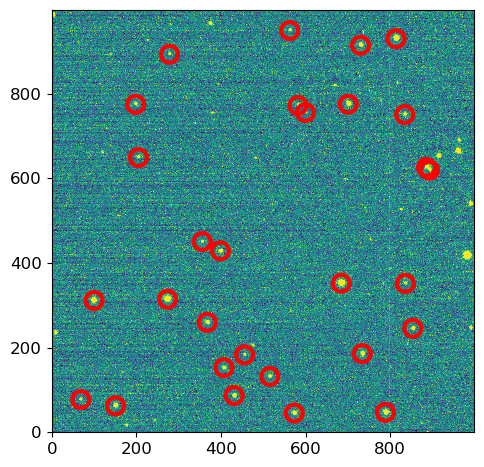

In [14]:
pos_stars = SkyCoord(result["RAJ2000"], result["DEJ2000"], unit='deg')
pos_stars = pos_stars.to_pixel(wcs=w)
ap_stars = CAp(positions=pos_stars, r=20)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.zimshow(axs, hdul[0].data)
ap_stars.plot(color='r', lw=3)
plt.tight_layout()

As can be seen, many more objects are queried! As Pan-STARRS catalog is available, I recommend all of you to use Pan-STARRS rather than UCAC catalog because 
1. It covers larger region of celestial sphere
2. Better accuracy
3. More objects with fainter flux

## 7. Pan-STARRS and Johnson-Cousins Filter Systems

One unfortunate thing for us is that, Pan-STARRS 1 (PS1) has only [$ \mathrm{(g r i z y)_{P1}} $ filters](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Filter+properties), not $ \mathrm{U B V R_C I_C} $. There are few ways to convert SDSS magnitudes to $ \mathrm{U B V R_C I_C} $ magnitudes:
1. [Jestor et al.(2005) method](http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jester2005): $ \mathrm{V} = \mathrm{g} − 0.59(\mathrm{g − r})−0.01 $ (RMS 0.01 mag) 
2. [Lupton et al.(2005) method](http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Lupton2005): $ \mathrm{V} = \mathrm{g} − 0.5784 (\mathrm{g − r}) − 0.0038 $ (RMS 0.0054 mag)

We assume here that SDSS and PS1 filters are identical, e.g., $ \mathrm{g_{P_1}} = \mathrm{g'_{SDSS}} $ (differ only less than uncertainty).

BachYP, IshiguroM et al. (2019, JKAS, under review) described in the [on-line material](https://nbviewer.jupyter.org/github/ysbach/KMTNet_Toutatis/blob/master/Notebooks/01_data_reduction.ipynb#SDSS-to-V-Conversion) that these two methods differ systematically by only around 0.01 magnitude. Here, I will use Lupton's method.

In [15]:
result["Vmag"] = result["gmag"] - 0.5784 * (result["gmag"] - result["rmag"]) - 0.0038
print(result["Vmag"].round(3))
# result

 Vmag 
------
18.089
17.321
18.766
17.928
17.695
19.421
18.202
17.784
 16.73
19.128
   ...
  18.9
18.002
18.764
 18.49
19.703
17.458
19.278
19.119
19.201
 17.88
16.734
Length = 29 rows


Once you have determined the instrumental magnitudes of the stars and subtract it from these catalogued magnitude, and taking mean, you will get the zero point. Add this zero point to the instrumental magnitude of the object to obtain object's real magnitude.